<a href="https://colab.research.google.com/github/Elmir22/Data-science-ML-models-/blob/main/deep_computer_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.datasets import load_sample_images
import tensorflow as tf
import matplotlib.pyplot as plt


(-0.5, 639.5, 426.5, -0.5)

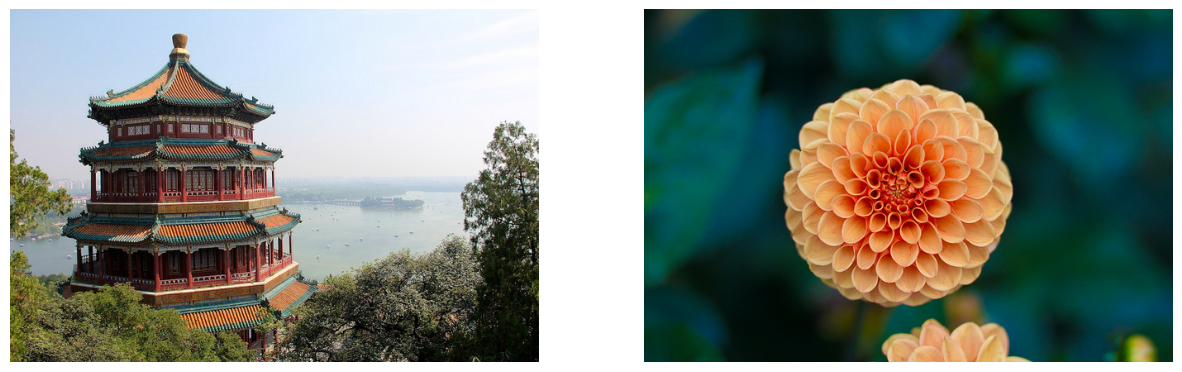

In [3]:
images = load_sample_images()['images']
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(images[0])
plt.axis('off')
plt.subplot(122)
plt.imshow(images[1])
plt.axis('off')

(-0.5, 119.5, 69.5, -0.5)

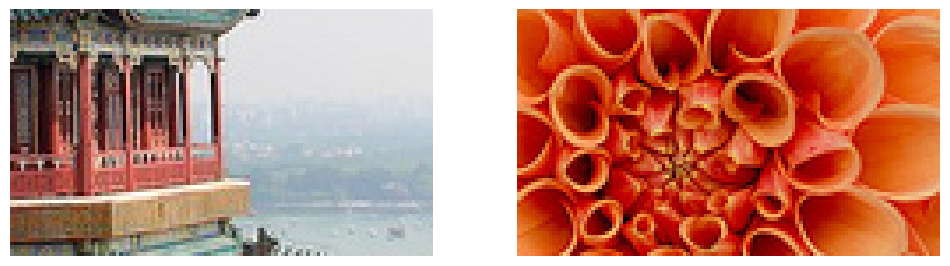

In [4]:
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(images[0])
plt.axis('off')
plt.subplot(122)
plt.imshow(images[1])
plt.axis('off')

In [5]:
images.shape

TensorShape([2, 70, 120, 3])

In [6]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [7]:
fmaps.shape

TensorShape([2, 64, 114, 32])

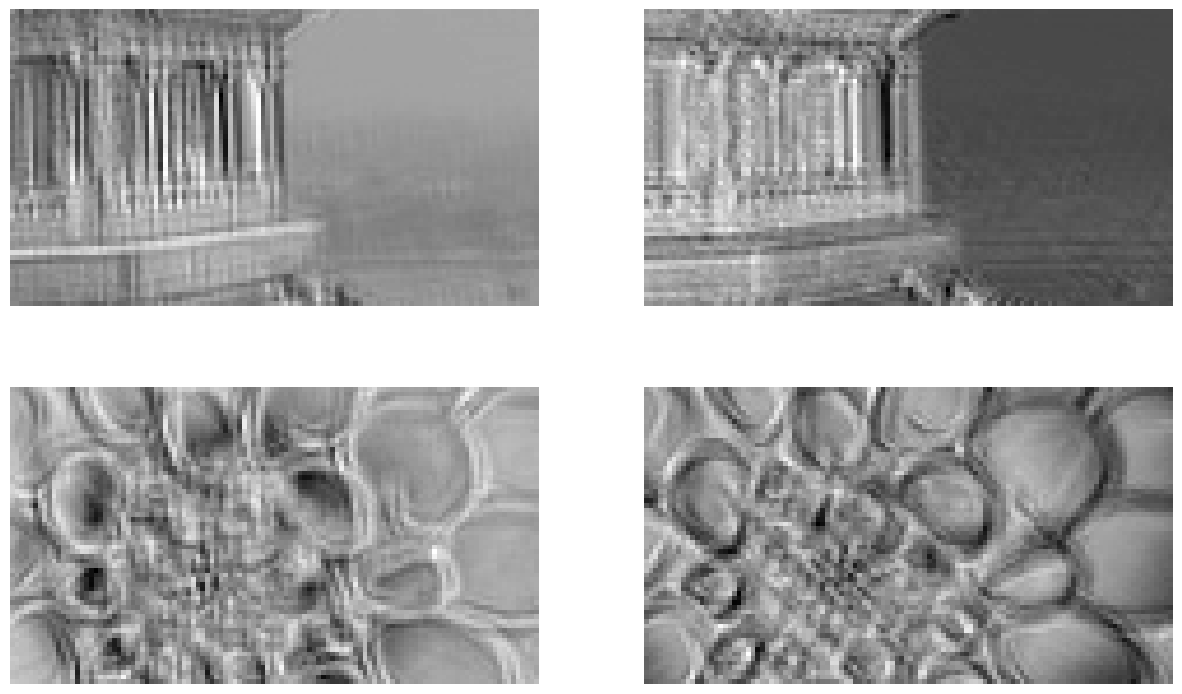

In [8]:
plt.figure(figsize=(15,9))
for image_idx in  (0,1):
    for fmap_idx in (0,1):
      plt.subplot(2,2 ,image_idx * 2 + fmap_idx + 1)
      plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap = 'gray')
      plt.axis("off")

plt.show()

In [9]:
conv_layer = tf.keras.layers.Conv2D(filters = 32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [10]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [11]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding = "same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [12]:
import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=10, strides=4, padding="same")

(array([18, 30]), array([8, 6]))

In [13]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [14]:
tf.random.set_seed(42)
filters = tf.random.normal([7,7,3,2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME")+ biases

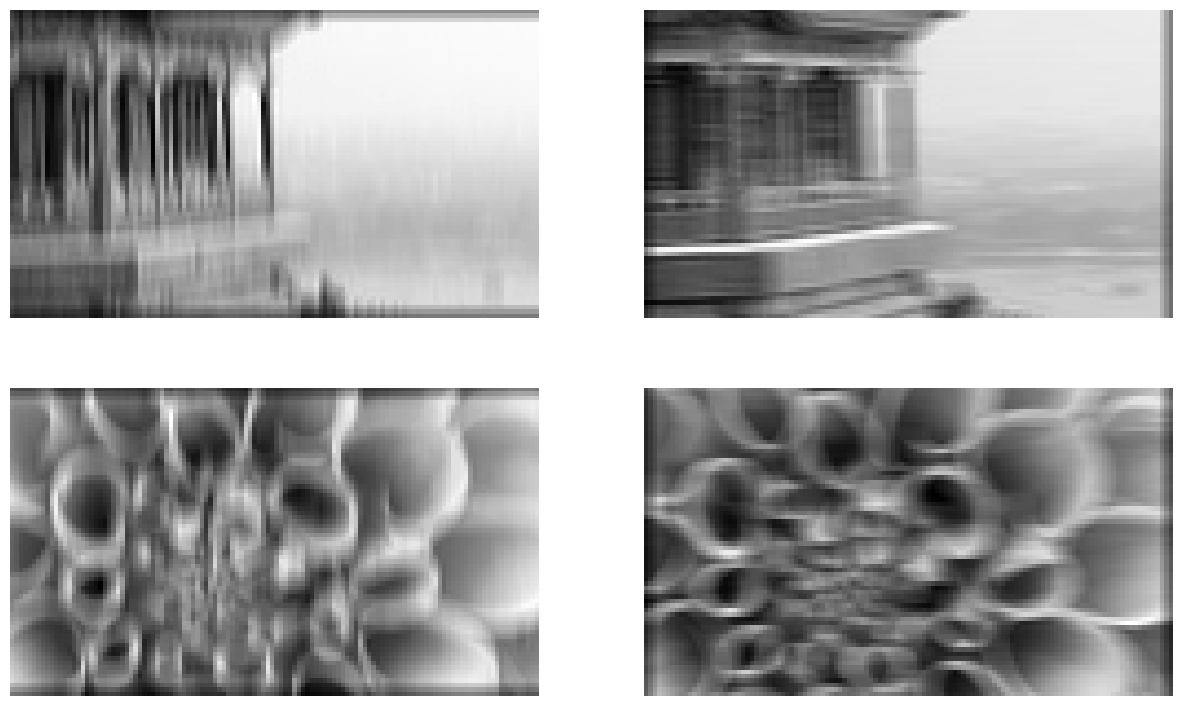

In [15]:
plt.figure(figsize=(15,9))
filters = np.zeros([7,7,3,2])
filters[:,3, :, 0] = 1
filters[3,:,:,1]=1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0,1):
  for fmap_idx in (0,1):
    plt.subplot(2,2, image_idx*2+fmap_idx + 1)
    plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
    plt.axis("off")

plt.show()

In [16]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)


In [17]:
output = max_pool(images)

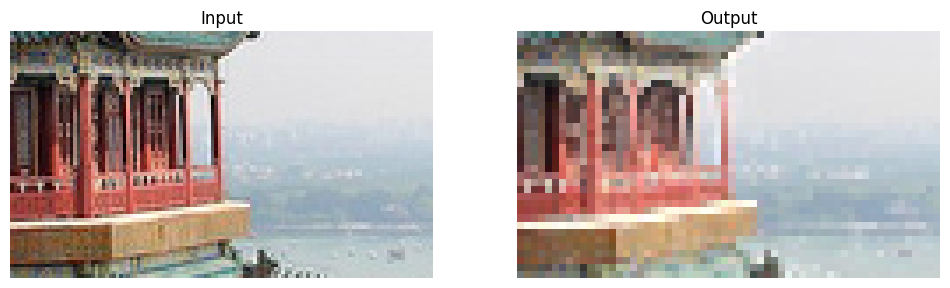

In [18]:
import matplotlib as mpl
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [2,2])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("Input")
ax1.imshow(images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("Output")
ax2.imshow(output[0])
ax2.axis('off')
plt.show()

#class DepthPool

In [19]:
class DepthPool(tf.keras.layers.Layer):
  def __init__(self, pool_size=2, **kwargs):
    super().__init__(**kwargs)
    self.pool_size = pool_size


  def call(self, inputs):
    shape = tf.shape(inputs)
    groups = shape[-1] // self.pool_size
    new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
    return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

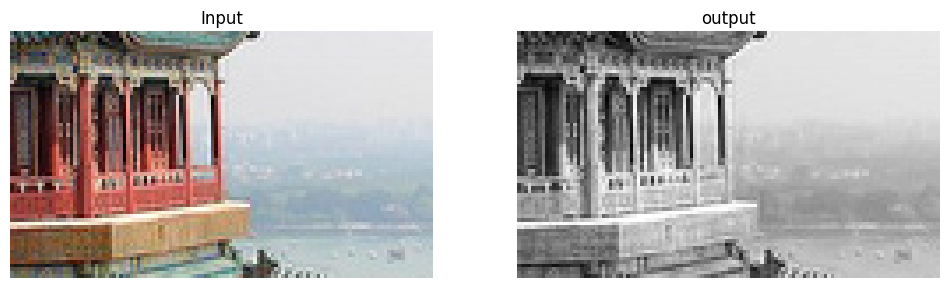

In [20]:
depth_output =  DepthPool(pool_size=3)(images)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Input')
plt.imshow(images[0])
plt.axis('off')
plt.subplot(1,2,2)
plt.title('output')
plt.imshow(images[0, ... ,0], cmap="gray")
plt.axis("off")
plt.show()

#CNN architectures

#Tackling Fashion MNIST With a CNN

In [21]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [22]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3,padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28,28,1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [24]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
x_new = X_test[:10]
y_pred = model.predict(x_new)

Epoch 1/10
1719/1719 [==============================] - 19s 9ms/step - loss: 0.2124 - accuracy: 0.9297 - val_loss: 0.2448 - val_accuracy: 0.9196
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.1934 - accuracy: 0.9347 - val_loss: 0.2804 - val_accuracy: 0.9124
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.1860 - accuracy: 0.9358 - val_loss: 0.3041 - val_accuracy: 0.9124
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.1907 - accuracy: 0.9344 - val_loss: 0.2574 - val_accuracy: 0.9182
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.1810 - accuracy: 0.9380 - val_loss: 0.2682 - val_accuracy: 0.9146
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.1768 - accuracy: 0.9397 - val_loss: 0.2953 - val_accuracy: 0.9162
Epoch 7/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.1773 - accuracy: 0.9410 - val_loss: 0.3280 - val_ac

In [25]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [26]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

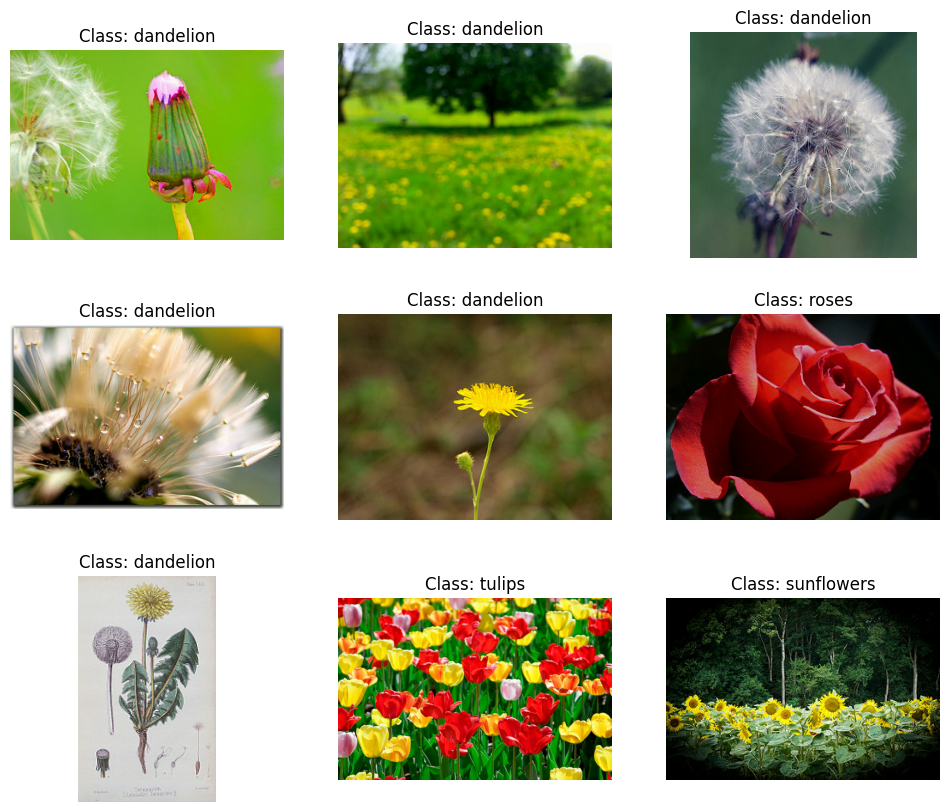

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
index = 0
for image, label in valid_set_raw.take(9):
  index +=1
  plt.subplot(3,3,index)
  plt.imshow(image)
  plt.title(f"Class: {class_names[label]}")
  plt.axis("off")

plt.show()

In [28]:
import tensorflow as tf
tf.keras.backend.clear_session()


batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set_raw.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [37]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])


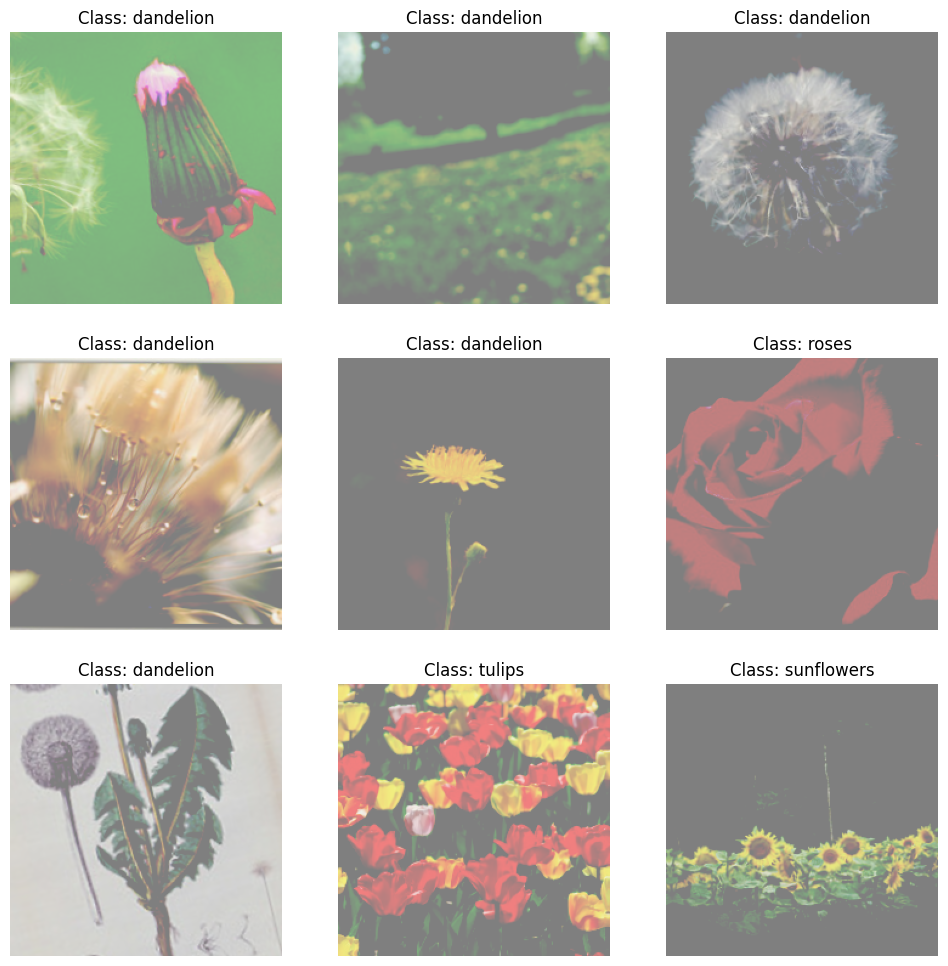

In [38]:
plt.figure(figsize=(12,12))
for X_batch, y_batch in valid_set.take(1):
  X_batch_augmented = data_augmentation(X_batch, training= True)
  for index in range(9):
    plt.subplot(3,3,index+1)
    plt.imshow(np.clip((X_batch_augmented[index]+1)/2,0,1))
    plt.title(f"Class: {class_names[y_batch[index]]}")
    plt.axis("off")
plt.show()

In [39]:
tf.random.set_seed(42)#extra code - ensure reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs= output)

In [40]:
for layer in base_model.layers:
  layer.trainable= False

In [42]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [43]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 26s 194ms/step - loss: 0.7750 - accuracy: 0.8081 - val_loss: 0.8260 - val_accuracy: 0.8240
Epoch 2/3
86/86 [==============================] - 15s 167ms/step - loss: 0.3189 - accuracy: 0.9157 - val_loss: 0.5659 - val_accuracy: 0.8566
Epoch 3/3
86/86 [==============================] - 15s 163ms/step - loss: 0.1860 - accuracy: 0.9404 - val_loss: 0.9489 - val_accuracy: 0.8203


In [44]:
for indices in zip(range(33), range(33,66), range(66,99), range(99,132)):
  for idx in indices:
    print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
  print()

  0: input_3                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_10 67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_26                 68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_33                
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [45]:
for layer in base_model.layers[56:]:
  layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history= model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 40s 321ms/step - loss: 0.3083 - accuracy: 0.9059 - val_loss: 0.4646 - val_accuracy: 0.8748
Epoch 2/10
86/86 [==============================] - 27s 299ms/step - loss: 0.0497 - accuracy: 0.9844 - val_loss: 0.3476 - val_accuracy: 0.9111
Epoch 3/10
86/86 [==============================] - 27s 302ms/step - loss: 0.0145 - accuracy: 0.9953 - val_loss: 0.3517 - val_accuracy: 0.9020
Epoch 4/10
86/86 [==============================] - 28s 308ms/step - loss: 0.0134 - accuracy: 0.9964 - val_loss: 0.3484 - val_accuracy: 0.9002
Epoch 5/10
86/86 [==============================] - 27s 306ms/step - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.3600 - val_accuracy: 0.9056
Epoch 6/10
86/86 [==============================] - 26s 297ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.3866 - val_accuracy: 0.8966
Epoch 7/10
86/86 [==============================] - 26s 298ms/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 0.3831 - val_accuracy: 0.9093

#Classification and Localization

In [49]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model= tf.keras.Model(inputs= base_model.input,
                      outputs = [class_output, loc_output])

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              optimizer= optimizer, loss_weights=[0.8, 0.2],
              metrics=["accuracy"])

In [50]:
def add_random_bounding_boxes(images, labels):
  fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
  return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 [==============================] - 22s 497ms/step - loss: 1.2553 - dense_2_loss: 1.5011 - dense_3_loss: 0.2724 - dense_2_accuracy: 0.3656 - dense_3_accuracy: 0.2688
Epoch 2/2
10/10 [==============================] - 6s 500ms/step - loss: 0.8447 - dense_2_loss: 1.0031 - dense_3_loss: 0.2112 - dense_2_accuracy: 0.7375 - dense_3_accuracy: 0.2469
